# Thermalization-inspired training of Restricted Boltzmann machines
## Notebook 3

Based on my recent thinking, I'm implementing here a quantum-mechanics-inspired RBM.

- For simplicity, I start with a single visible and hidden unit each for the system and bath

- Each node ($v_S, h_S, v_B, h_B$) can be pictured as a two-level system (classically, using random variable taking values $\{0,1\}$), or quantum mechanically using the matrix $\mathrm{diag}(0,1)$). 

- The energy gap of each node is equal to the corresponding bias of that node in the energy function

- The bath state is described by an exponential form $\rho_B = \exp(-(\omega_V v_B + \omega_H h_B + J v_B h_B) -\log Z_B))$, which is diagonal

- The bath Hamiltonian is arranged such that only two configurations appear with non-vanishing probability (say, $00$ and $11$)

- The bath state is frequently updated by drawing from the above distribution

- The system begins in a random state (say 00)

- The system Hamiltonian is *not* diagonal! This is in order to ensure that there is some conon-trivial self-evolution going on, so that information can propagate between visible and hidden units

- It may be convenient to periodically project the system onto diagonal states

- The system and bath have a simple SWAP interaction (perhaps collapsed onto the diagonal

- The goal: at equilibrium, the *system* should also be in the state $\rho_S = \exp(-(\omega_V v_B + \omega_H h_B + J v_B h_B) -\log Z_B))$

In [1]:
import numpy as np
import scipy as sp
import qutip as qt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Node(object):
    def __init__(self, energy = 1.0, state = np.array([1.0, 0.0]), name = None):
        self.state = state
        self.energy = energy
        self.name = name
        
    def __str__(self):
        if self.name is not None:
            node_string = 'Node "{}"\n'.format(self.name)
        else: 
            node_string = 'Unnamed Node:'
        node_string += 'Energy: {0}\nCurrent state: {1}'.format(self.energy,self.state)
        return node_string
    
    def update_state(self, new_state):
        self.state = new_state
        return
    
class Layer(object):
    def __init__(self, num_nodes, states='default', energies='default', name = None):
        self.num_nodes = num_nodes
        if name is not None:
            self.name = name
        else:
            self.name = "Unnamed"
        
        default_state = np.array([1.0,0.0])
        default_energy = 1.0
        
        self.nodes = []
        for ctr in range(self.num_nodes):
            if states == 'default':
                node_state = default_state
            else:
                if np.shape(states)[0] != num_nodes: 
                    print 'Warning: states are inconsistent with num_nodes, using default value'
                    node_state = default_state 
                else:
                    node_state = states[ctr]
            if energies == 'default':
                node_energy = default_energy
            else:
                if len(energies) != num_nodes:
                    print 'Warning: energies are inconsistent with num_nodes, using default value'
                    node_energy = default_energy
                else:
                    node_energy = energies[ctr]
            node_name = self.name + str(ctr)            
            self.nodes.append(Node(energy = node_energy, state = node_state, name = node_name))
            
    def __str__(self):
        layer_string = 'Layer "{0}"\n*************************\nNumber of nodes: {1}\n\n'.format(self.name,self.num_nodes)
        layer_string += 'Layer contains:\n-------------------\n'
        for node in self.nodes:
            layer_string += node.__str__()+'\n-------------------\n'
        return layer_string
    
    def update_nodes(self, new_states):
        for ctr, state in enumerate(new_states):
            self.nodes[ctr].update_state(state)
            
    def node_states(self):
        states = []
        for node in self.nodes:
            states.append(node.state)
        return states
            
class System(object):
    def __init__(self, name = None):
        self.name = name
        self.layers = {}
        self.couplings = {}
        
    def __str__(self):
        if self.name == None:
            system_string = 'Unnamed system'
        else: 
            system_string = 'System "{0}"'.format(self.name)
        system_string += ':\n============================\n\n'
        
        if len(self.layers) == 0:
            system_string += 'Currently no layers specified.'
        else:
            system_string += 'Layers:\n\n'
            for layer in self.layers.values():
                system_string += layer.__str__() + '\n'
        system_string += '*************************\n\n'
        
        if len(self.couplings.values()) == 0:
            system_string += 'Currently no couplings specified.\n\n'
        else:
            system_string += 'Couplings:\n\n'
            for name, coupling in self.couplings.items():
                system_string += name + ':\n'
                system_string += str(coupling)+'\n-------------------\n'
        
        return system_string
    
    def add_layer(self, num_nodes, states='default', energies='default', name = None):
        layer_name = name
        new_layer = Layer(num_nodes, states=states, energies=energies, name = layer_name)
        self.layers[layer_name]=new_layer
        
    def couple_layers(self, layerX, layerY, couplings):
        if layerX in self.layers.keys() and layerY in self.layers.keys():
            self.couplings[layerX+'_to_'+layerY]=couplings
            #need to check couplings for consistency...

In [8]:
#helper functions

def prob_to_binary(probs):
    return np.random.binomial(1,probs)

def update_bath(bath, state_type, beta = 0):
    #for simplicity, don't actually encode the exponential distribution
    if state_type == 'vh_correlated':
        prob = 1/(1+np.exp(-beta))
        b = np.random.binomial(1,prob)
        bath.layers['Visible'].update_nodes([[b,1-b]])
        bath.layers['Hidden'].update_nodes([[b,1-b]])
    else:
        print 'Warning. Incompatible state_type. Not updating bath.'
    return bath

def interact_visible(sys1, sys2, density_matrix = None, mixing_prob = 0.1):
    m = mixing_prob
    
    if density_matrix is not None:
        rho = density_matrix
    else:
        rho = sys_to_product_dm(sys1) #make density matrix from classical populations    
    
    sys1_state = np.array(sys1.layers['Visible'].node_states())
    sys2_state = np.array(sys2.layers['Visible'].node_states())   
    
    rho = (1-m)*rho + m*sys_to_product_dm(sys2)

    #note: assumes evolution_method == 'measure_diag':
    #convert bloch vectors to their diagonal components, then measure in 0/1 basis
    rho_V = rho.ptrace(0)
    vis_prob = rho_V[0,0]
    vis_binary = prob_to_binary(vis_prob)
    new_visible_state = [vis_binary,1-vis_binary]
    
    sys1.layers['Visible'].update_nodes([new_visible_state])

    #sys1.layers['Visible'].update_nodes((1-m)*sys1_state + m*sys2_state) #no longer used    
    sys2.layers['Visible'].update_nodes((1-m)*sys2_state + m*sys1_state)
    
    return sys1, sys2, rho

def get_states(sys):
    visible = np.array(sys.layers['Visible'].node_states()).flatten()
    hidden = np.array(sys.layers['Hidden'].node_states()).flatten()
    return visible, hidden

def sys_to_product_dm(sys):
    visible, hidden = get_states(sys)
    rho_V = qt.Qobj(np.diag(visible))
    rho_H = qt.Qobj(np.diag(hidden))
    rho = qt.tensor(rho_V, rho_H)  
    return rho

def evolve_sys(sys, generator, time, evolution_method = 'measure_diag', density_matrix = None):
    if density_matrix is not None:
        rho = density_matrix
    else:
        rho = sys_to_product_dm(sys) #make density matrix from classical populations

    #for the moment, assume generator is a 2-qubit Hamiltonian
    
    #Note: the below code was numerically unstable 
    #the expm operation "leaks out" probability over time
    #I have included the renormalization hack to prevent this
    H = qt.Qobj(generator)
    H.dims = [[2,2],[2,2]]
    U = (1j*time*H).expm()
    rho = U*rho*U.conj()
    rho = rho/rho.tr()
    
    rho_V = rho.ptrace(0)
    rho_H = rho.ptrace(1)

    if evolution_method == 'project_diag':
        #convert bloch vectors to their diagonal components
        new_visible_state = rho_V.diag()
        new_hidden_state = rho_H.diag() 
    elif evolution_method == 'measure_diag':
        #convert bloch vectors to their diagonal components, then measure in 0/1 basis
        vis_prob = rho_V[0,0]
        vis_binary = prob_to_binary(vis_prob)
        new_visible_state = [vis_binary,1-vis_binary]
        hid_prob = rho_H[0,0]
        hid_binary = prob_to_binary(hid_prob)
        new_hidden_state = [hid_binary,1-hid_binary]
    else:
        print 'Invalid evolution_method. Keeping states fixed.'
        new_visible_state = visible
        new_hidden_state = hidden
    
    sys.layers['Visible'].update_nodes([new_visible_state])
    sys.layers['Hidden'].update_nodes([new_hidden_state])
    
    return rho

def initialize():
    #set up system with random energies and couplings
    NUM_V_SYS = 1
    NUM_H_SYS = 1
    sys = System('RBM')
    sys.add_layer(NUM_V_SYS, name = 'Visible', energies = np.random.normal(size=NUM_V_SYS))
    sys.add_layer(NUM_H_SYS, name = 'Hidden', energies = np.random.normal(size=NUM_H_SYS))
    sys.couple_layers('RBM_Visible','RBM_Hidden',np.random.normal(size=(NUM_V_SYS,NUM_H_SYS)))
    
    #bath has fixed energies/couplings
    NUM_V_BATH = 1
    NUM_H_BATH = 1
    omega_V_bath = 1.0
    omega_H_bath = 1.0
    J = -2.0
    beta_bath = 0.01
    bath = System('Bath')
    bath.add_layer(NUM_V_BATH, name = 'Visible', energies = [omega_V_bath])
    bath.add_layer(NUM_H_BATH, name = 'Hidden', energies = [omega_H_bath])
    bath.couple_layers('Bath_Visible','Bath_Hidden', J)
    
    return sys, bath

# Run simulations

#### System disconnected from bath (self-evolution)

/home/coolguy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: ComplexWarning: Casting complex values to real discards the imaginary part


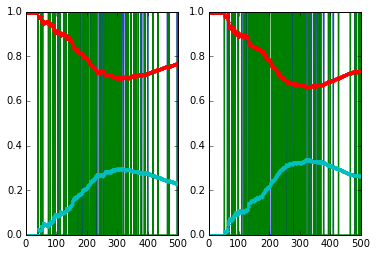

In [50]:
#iterate over many evolution steps
num_steps = 500
mixing_prob = 0.05
time_step = 0.005
H = np.random.uniform(size=(4,4))
H = (H+H.T)/2
sys, bath = initialize()
evolution_method = 'measure_diag'
rho = sys_to_product_dm(sys)
store_rho = [rho]
bath_state = 'vh_correlated'
beta = 100.0

for ctr in range(num_steps):
    #bath = update_bath(bath,bath_state,beta)
    #sys, bath, rho = interact_visible(sys, bath, rho, mixing_prob)
    rho = evolve_sys(sys, H, time_step, density_matrix = rho)
    store_rho.append(rho)
    
    sys_visible, sys_hidden = get_states(sys)
    if ctr == 0:
        store_visible = sys_visible
        store_hidden = sys_hidden
    else:
        store_visible = np.vstack((store_visible, sys_visible))
        store_hidden = np.vstack((store_hidden, sys_hidden))  

vis_mean = np.array([list(np.mean(store_visible[0:x],axis=0)) for x in range(1,num_steps)])  
hid_mean = np.array([list(np.mean(store_hidden[0:x],axis=0)) for x in range(1,num_steps)])
store_rho_H = [rho.ptrace(0) for rho in store_rho]
store_rho_V = [rho.ptrace(1) for rho in store_rho]
    
ax1 = plt.subplot(1,2,1);
plt.plot(store_visible);
plt.plot(vis_mean ,'.');
plt.subplot(1,2,2,sharey = ax1);
plt.plot(store_hidden);
plt.plot(hid_mean ,'.');
ax1.set_ylim([0.0,1.0]);

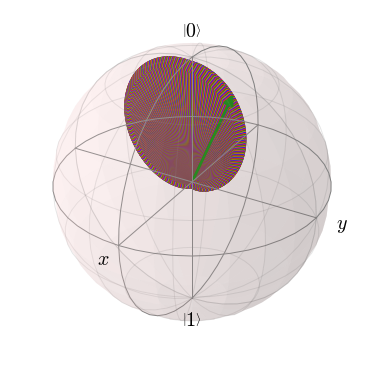

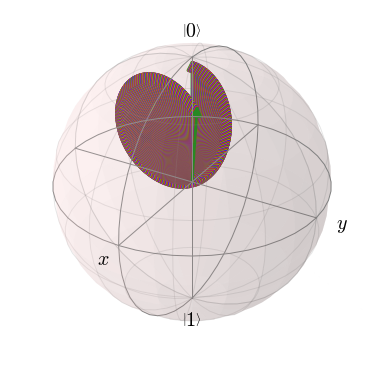

In [51]:
b = qt.Bloch()
b.add_states(store_rho_V)
b.show()
c = qt.Bloch()
c.add_states(store_rho_H)
c.show()

#### System connected to high-temperature correlated bath

/home/coolguy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: ComplexWarning: Casting complex values to real discards the imaginary part


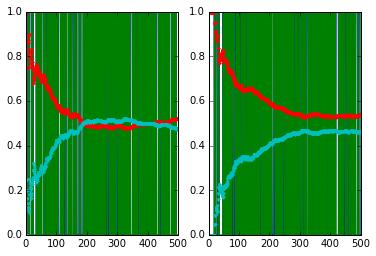

In [52]:
#iterate over many evolution steps
num_steps = 500
mixing_prob = 0.05
time_step = 0.005
np.random.seed(0)
H = np.random.uniform(size=(4,4))
H = (H+H.T)/2
sys, bath = initialize()
evolution_method = 'measure_diag'
rho = sys_to_product_dm(sys)
store_rho = [rho]
bath_state = 'vh_correlated'
beta = 0.0

for ctr in range(num_steps):
    bath = update_bath(bath,bath_state,beta)
    sys, bath, rho = interact_visible(sys, bath, rho, mixing_prob)
    rho = evolve_sys(sys, H, time_step, density_matrix = rho)
    store_rho.append(rho)
    
    sys_visible, sys_hidden = get_states(sys)
    if ctr == 0:
        store_visible = sys_visible
        store_hidden = sys_hidden
    else:
        store_visible = np.vstack((store_visible, sys_visible))
        store_hidden = np.vstack((store_hidden, sys_hidden))  

vis_mean = np.array([list(np.mean(store_visible[0:x],axis=0)) for x in range(1,num_steps)])  
hid_mean = np.array([list(np.mean(store_hidden[0:x],axis=0)) for x in range(1,num_steps)])
store_rho_H = [rho.ptrace(0) for rho in store_rho]
store_rho_V = [rho.ptrace(1) for rho in store_rho]
        
ax1 = plt.subplot(1,2,1);
plt.plot(store_visible);
plt.plot(vis_mean ,'.');
plt.subplot(1,2,2,sharey = ax1);
plt.plot(store_hidden);
plt.plot(hid_mean ,'.');
ax1.set_ylim([0.0,1.0]);

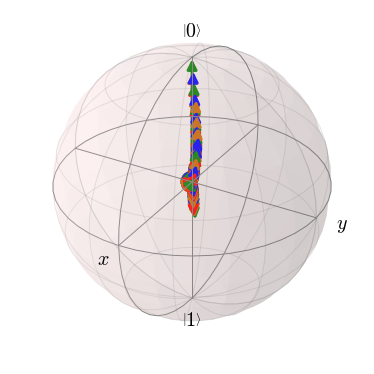

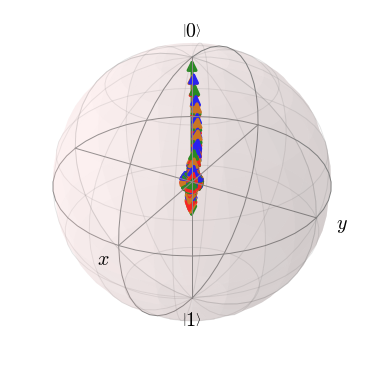

In [53]:
b = qt.Bloch()
b.add_states(store_rho_V)
b.show()
c = qt.Bloch()
c.add_states(store_rho_H)
c.show()

#### System connected to low-temperature  correlated bath

/home/coolguy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: ComplexWarning: Casting complex values to real discards the imaginary part


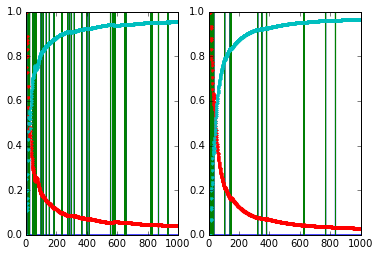

In [59]:
#iterate over many evolution steps
num_steps = 1000
mixing_prob = 0.05
time_step = 0.005
np.random.seed(0)
H = np.random.uniform(size=(4,4))
H = (H+H.T)/2
sys, bath = initialize()
evolution_method = 'measure_diag'
rho = sys_to_product_dm(sys)
store_rho = [rho]
bath_state = 'vh_correlated'
beta = -100.0

for ctr in range(num_steps):
    bath = update_bath(bath,bath_state,beta)
    sys, bath, rho = interact_visible(sys, bath, rho, mixing_prob)
    rho = evolve_sys(sys, H, time_step, density_matrix = rho)
    store_rho.append(rho)
    
    sys_visible, sys_hidden = get_states(sys)
    if ctr == 0:
        store_visible = sys_visible
        store_hidden = sys_hidden
    else:
        store_visible = np.vstack((store_visible, sys_visible))
        store_hidden = np.vstack((store_hidden, sys_hidden))  

vis_mean = np.array([list(np.mean(store_visible[0:x],axis=0)) for x in range(1,num_steps)])  
hid_mean = np.array([list(np.mean(store_hidden[0:x],axis=0)) for x in range(1,num_steps)])
store_rho_H = [rho.ptrace(0) for rho in store_rho]
store_rho_V = [rho.ptrace(1) for rho in store_rho]
             
ax1 = plt.subplot(1,2,1);
plt.plot(store_visible);
plt.plot(vis_mean ,'.');
plt.subplot(1,2,2,sharey = ax1);
plt.plot(store_hidden);
plt.plot(hid_mean ,'.');
ax1.set_ylim([0.0,1.0]);

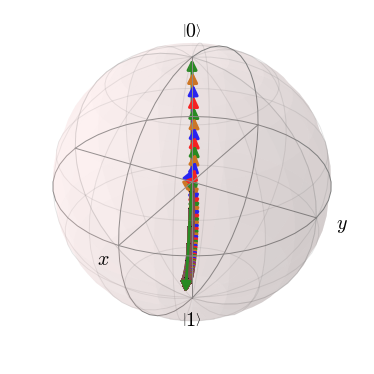

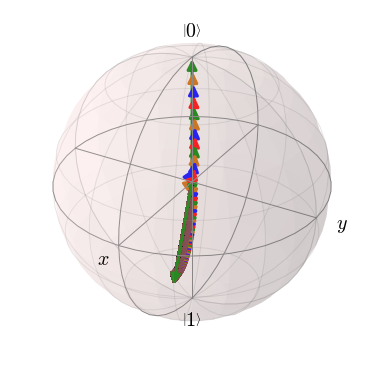

In [60]:
b = qt.Bloch()
b.add_states(store_rho_V)
b.show()
c = qt.Bloch()
c.add_states(store_rho_H)
c.show()

In [61]:
#compare with thermal state of this Hamiltonian at inverse temp beta
rho

Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = True
Qobj data =
[[ 0.00561246+0.j          0.00907569+0.00100706j  0.00309360-0.00068295j
  -0.00907221+0.0516526j ]
 [ 0.00907569-0.00100706j  0.01492203+0.j          0.00483568-0.00166046j
  -0.00871599+0.0855929j ]
 [ 0.00309360+0.00068295j  0.00483568+0.00166046j  0.00181835+0.j
  -0.00904325+0.02703111j]
 [-0.00907221-0.0516526j  -0.00871599-0.0855929j  -0.00904325-0.02703111j
   0.97764717+0.j        ]]

In [65]:
t = sp.linalg.expm(-beta*H)
t = t/np.trace(t)
t

array([[ 0.28200478,  0.2849162 ,  0.26717758,  0.22342109],
       [ 0.2849162 ,  0.28785768,  0.26993593,  0.22572769],
       [ 0.26717758,  0.26993593,  0.25312996,  0.21167409],
       [ 0.22342109,  0.22572769,  0.21167409,  0.17700758]])

In [64]:
np.diag([t[0,0]+t[1,1], t[2,2]+t[3,3]])

array([[ 0.56986246,  0.        ],
       [ 0.        ,  0.43013754]])

In [63]:
rho.ptrace(0)

Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = True
Qobj data =
[[ 0.02053448+0.j         -0.00562239+0.08490995j]
 [-0.00562239-0.08490995j  0.97946552+0.j        ]]

In [66]:
rho.ptrace(1)

Quantum object: dims = [[2], [2]], shape = [2, 2], type = oper, isherm = True
Qobj data =
[[  7.43080469e-03+0.j           3.24375686e-05+0.02803816j]
 [  3.24375686e-05-0.02803816j   9.92569195e-01+0.j        ]]

### Summary

- if I force-project onto diagonal after evolution ('project_diag'), then system always gets pushed towards maximally mixed state. This happens because the force-projection onto diagonal *always reduces the purity* [I should no longer consider this]

- if I measure in the 0/1 basis ('measure_diag'), then the visible part of the system takes on similar characteristics as the visible part of the bath

- Near steady state, clearly the full system is not in a $\beta$-thermal state of the global Hamiltonian (notice: the ground/ceiling state of the global Hamiltonian will generally be an entangled state)

- rather, the state $\rho_V$ is locally in a thermal state, with a similar temperature as the visible unit of the bath (in fact, this is also true for $\rho_H$)

- Thus, the distribution $\exp(-\beta(H_V+H_H))$ (for some local Hamiltonians) better describes the system than $\exp(-\beta(H_\mathrm{sys}))$